In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.resnet import ResNet, BasicBlock
from config import CFG
from tqdm import tqdm
from typing import Optional


import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [2]:
epoch=5
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_channels=3
first_fmap_channels=64
last_fmap_channels=512

output_channels=3
time_embedding=256
learning_rate=1e-4

min_lr=1e-6
weight_decay=0.0
n_timestpes=500

beta_min=1e-4 #0.0001
beta_max=2e-2 #0.02
beta_scheduler='linear'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.88235295].


min pixel value: tensor(-0.9922)
max pixel value: tensor(0.8824)


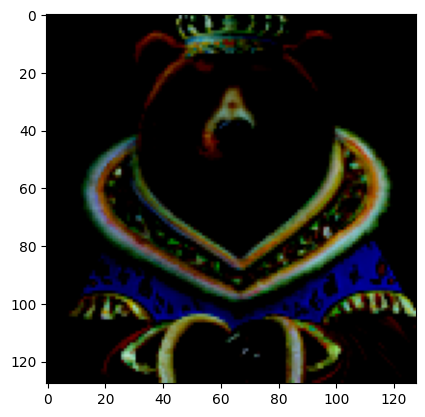

In [3]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1] 범위로 변환
])

train_dataset=ImageFolder(root='C:/Users/admin/Desktop/VSC/custom_AI_data',
                     transform=transform)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=12,shuffle=True)

print('min pixel value:',train_dataset.__getitem__(100)[0].min())
print('max pixel value:',train_dataset.__getitem__(100)[0].max())
sample_image=train_dataset.__getitem__(100)[0]
plt.imshow(train_dataset.__getitem__(100)[0].permute(1,2,0))
plt.show()


In [4]:
class DiffusionUtils:
    def __init__(self,n_timestpes,beta_min,beta_max, device,scheduler='linear'):
        self.n_timestpes=n_timestpes
        self.beta_min=beta_min
        self.beta_max=beta_max
        self.device=device
        self.scheduler=scheduler

        self.betas=self.betaSamples()
        self.alphas=1-self.betas
        self.alphas_hat=torch.cumprod(self.alphas,dim=0)

    def betaSamples(self):
        if self.scheduler=='linear':
            return torch.linspace(self.beta_min,self.beta_max,self.n_timestpes).to(self.device)
        elif self.scheduler=='cosine':
            betas=[]
            for i in reversed(range(self.n_timestpes)):
                T=self.n_timestpes-1
                beta=self.beta_min+0.5*(self.beta_max-self.beta_min)*(1+math.cos(i*math.pi/T))
                betas.append(beta)
            return torch.Tensor(betas).to(self.device)
        
    def sampleTimestep(self,size):
        return torch.randint(low=1,high=self.n_timestpes,size=(size,),device=self.device)
    
    def noiseImage(self,x,t):
        alpha_hat_sqrts=torch.sqrt(self.alphas_hat[t])[:,None,None,None]
        one_mins_alpha_hat_sqrt=torch.sqrt(1-self.alphas_hat[t])[:,None,None,None]
        noise=torch.randn_like(x).to(self.device)
        return (alpha_hat_sqrts*x+one_mins_alpha_hat_sqrt*noise),noise
    
    def sample(self,x,model):
        model.eval()
        with torch.no_grad():
            for i in reversed(range(self.n_timestpes)):
                t=(torch.ones(x.shape[0])*i).long().to(self.device)

                alpha=self.alphas[t][:,None,None,None]
                beta=self.betas[t][:,None,None,None]
                alpha_hat=self.alphas_hat[t][:,None,None,None]

                one_minus_alpha=1-alpha
                one_minus_alpha_hat=1-alpha_hat

                predicted_noise=model(x,t)

                if i>1:
                    noise=torch.randn_like(x).to(self.device)
                else:
                    noise=torch.zeros_like(x).to(self.device)

                x=1/torch.sqrt(alpha)*(x-((one_minus_alpha/torch.sqrt(one_minus_alpha_hat))*predicted_noise))
                x=x+(torch.sqrt(beta)*noise)

        return x


Scheduler: linear


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7382362..1.3706602].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4895468..2.07995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3414218..2.4315438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.807286..3.0926902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.164667..3.3847852].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1251345.

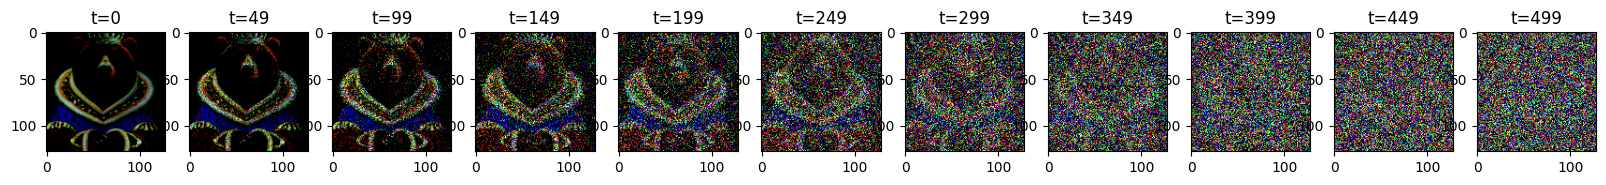

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3421764..1.0649565].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8876209..1.6180894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4296145..2.1468418].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2407558..2.5916076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6825287..3.1321683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.0150



Scheduler: cosine


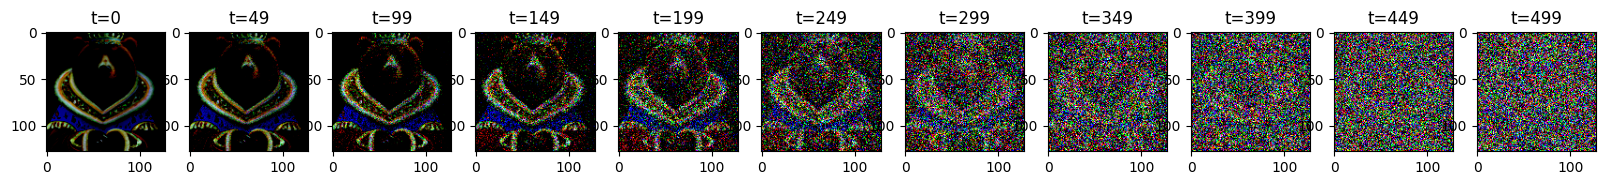

In [5]:
T=n_timestpes # 500
n_steps=50
alpha_values={}

for scheduler in ['linear','cosine']:
    print(f'Scheduler: {scheduler}')

    diffusion=DiffusionUtils(n_timestpes=T,beta_min=beta_min,beta_max=beta_max,device=device,scheduler=scheduler)
    alpha_values[scheduler]=diffusion.alphas

    fig,axs=plt.subplots(1,(T//n_steps)+1,figsize=(20,20))
    axs[0].imshow(sample_image.permute(1,2,0))
    axs[0].set_title('t=0')

    for idx,t in enumerate(range(n_steps-1,T,n_steps)):
        t=torch.Tensor([t]).long()
        x,_=diffusion.noiseImage(sample_image.unsqueeze(0).to(device),t)
        axs[idx+1].imshow(x.squeeze(0).cpu().permute(1,2,0))
        axs[idx+1].set_title(f't={t.item()}')

    plt.show()
    print('\n')
    


Text(0.5, 1.0, 'alpha values of cosine scheduling')

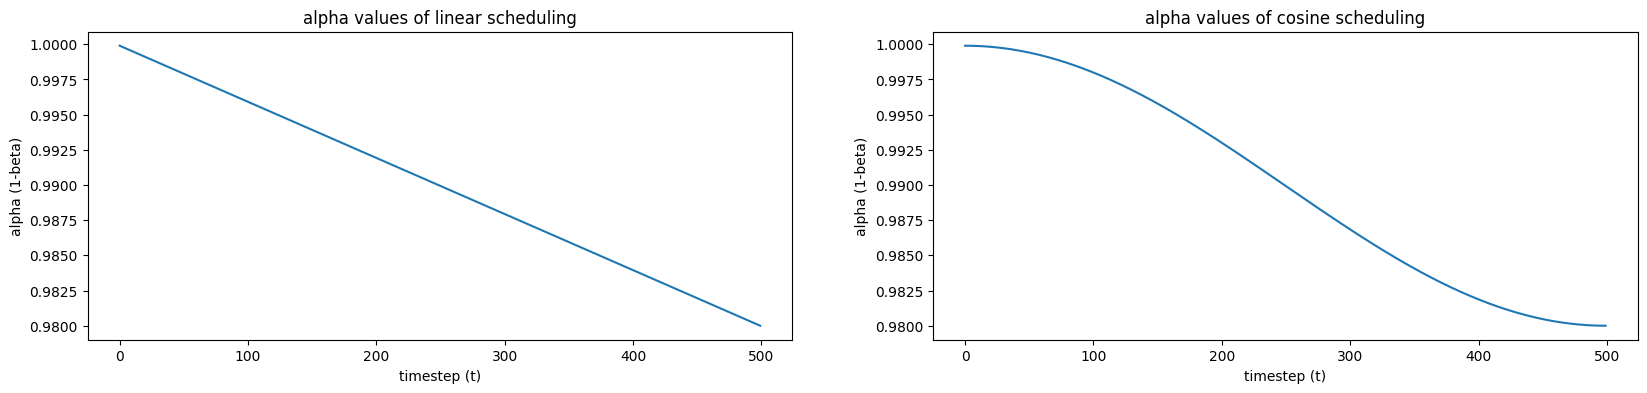

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(alpha_values['linear'].cpu())
axs[0].set_xlabel('timestep (t)')
axs[0].set_ylabel('alpha (1-beta)')
axs[0].set_title('alpha values of linear scheduling')

axs[1].plot(alpha_values['cosine'].cpu())
axs[1].set_xlabel('timestep (t)')
axs[1].set_ylabel('alpha (1-beta)')
axs[1].set_title('alpha values of cosine scheduling')

In [7]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self,dim_size,n=10000):
        super(SinusoidalEmbedding,self).__init__()

        self.dim_size=dim_size
        self.n=n

    def forward(self,x):
        N=len(x)
        output=torch.zeros((N,self.dim_size)).to(x.device)

        for idx in range(0,N):
            for i in range(0,self.dim_size//2):
                emd=x[idx]/(self.n**(2*i/self.dim_size))
                output[idx,2*i]=torch.sin(emd)
                output[idx,2*i+1]=torch.cos(emd)

        return output

In [8]:
class ImageSelfAttention(nn.Module):
    def __init__(self,input_channels,n_heads):
        super(ImageSelfAttention,self).__init__()

        self.input_channels=input_channels
        self.n_heads=n_heads

        self.layernorm=nn.LayerNorm(self.input_channels)
        self.attention=nn.MultiheadAttention(
            self.input_channels,
            num_heads=self.n_heads,
            batch_first=True
        )

    def forward(self,x):
        # shape of x: (N,C,H,W)
        _,C,H,W=x.shape

        x=x.reshape(-1,C,H*W).permute(0,2,1) # (N,H*W,C)
        normalised_x=self.layernorm(x)

        attn_val,_=self.attention(normalised_x,normalised_x,normalised_x)

        attn_val=attn_val+x
        attn_val=attn_val.permute(0,2,1).reshape(-1,C,H,W)

        return attn_val


In [9]:
class Encoder(ResNet):  #Resnet18
    def __init__(self,input_channels,time_embedding,block=BasicBlock,block_layers=[2,2,2,2],n_heads=4):
        super(Encoder,self).__init__(block,block_layers,input_channels)

        self.block=block
        self.block_layers=block_layers
        self.time_embedding=time_embedding
        self.input_channels=input_channels
        self.n_heads=n_heads

        #time embedding
        self.sinusoidal_embedding=SinusoidalEmbedding(dim_size=time_embedding,n=10000)
        fmap_channels=[64,64,128,256,512]
        self.time_projection_layers=self.make_time_projection_layers(fmap_channels)
        self.attention_layers=self.make_attention_layers(fmap_channels)

        self.conv1=nn.Conv2d(self.input_channels,fmap_channels[0],kernel_size=(7,7),stride=(2,2),padding=(3,3))
        self.conv2=nn.Conv2d(fmap_channels[0],fmap_channels[1],kernel_size=(7,7),stride=(2,2),padding=(3,3))

        del self.maxpool,self.fc,self.avgpool


    def forward(self,x,t):
        t=self.sinusoidal_embedding(t)
        
        fmap1=self.conv1(x)
        t_emb=self.time_projection_layers[0](t)
        fmap1=fmap1+t_emb[:,:,None,None]
        fmap1=self.attention_layers[0](fmap1)

        x=self.conv2(fmap1)
        x=self.bn1(x)
        x=self.relu(x)

        fmap2=self.layer1(x)
        t_emb=self.time_projection_layers[1](t)
        fmap2=fmap2+t_emb[:,:,None,None]
        fmap2=self.attention_layers[1](fmap2)

        fmap3=self.layer2(fmap2)
        t_emb=self.time_projection_layers[2](t)
        fmap3=fmap3+t_emb[:,:,None,None]
        fmap3=self.attention_layers[2](fmap3)

        fmap4=self.layer3(fmap3)
        t_emb=self.time_projection_layers[3](t)
        fmap4=fmap4+t_emb[:,:,None,None]
        fmap4=self.attention_layers[3](fmap4)


        fmap5=self.layer4(fmap4)
        t_emb=self.time_projection_layers[4](t)
        fmap5=fmap5+t_emb[:,:,None,None]
        fmap5=self.attention_layers[4](fmap5)

        return fmap1,fmap2,fmap3,fmap4,fmap5
    
    def make_time_projection_layers(self,fmap_channels):
        layers=nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.time_embedding,ch)
            )for ch in fmap_channels
        ])

        return layers
    
    def make_attention_layers(self,fmap_channels):
        layers=nn.ModuleList([
            ImageSelfAttention(ch,self.n_heads) for ch in fmap_channels
        ])
        return layers



In [10]:
class DecoderBlock(nn.Module):
    def __init__(self,input_channels,output_channels,time_embedding,upsample_scale=2,activation=nn.ReLU,compute_attn=True,n_heads=4):
        super(DecoderBlock,self).__init__()

        self.input_channels=input_channels
        self.output_channels=output_channels
        self.upsample_scale=upsample_scale
        self.time_embedding=time_embedding
        self.compute_attn=compute_attn
        self.n_heads=n_heads

        if self.compute_attn:
            self.attention=ImageSelfAttention(self.output_channels,self.n_heads)
        else:
            self.attention=nn.Identity() # 입력값을 그대로 출력으로

        self.sinusiodal_embedding=SinusoidalEmbedding(dim_size=self.time_embedding)

        self.time_projection_layer=nn.Sequential(
            nn.SiLU(),
            nn.Linear(self.time_embedding,self.output_channels)
        )
        self.transpose=nn.ConvTranspose2d(
            self.input_channels,
            self.input_channels,
            kernel_size=self.upsample_scale,
            stride=self.upsample_scale,
        )
        self.instance_norm1=nn.InstanceNorm2d(self.transpose.in_channels) #Batch 단위로 Instance들을 Normalize

        self.conv=nn.Conv2d(
            self.transpose.out_channels,
            self.output_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.instance_norm2=nn.InstanceNorm2d(self.conv.out_channels)
        self.activation=activation()

    #def forward(self,fmap,prev_fmap,t):
    def forward(self, fmap:torch.Tensor, prev_fmap:Optional[torch.Tensor]=None, t:Optional[torch.Tensor]=None):
        output=self.transpose(fmap)
        output=self.instance_norm1(output)
       
        output=self.conv(output)
        output=self.instance_norm2(output)

        if torch.is_tensor(prev_fmap):
            assert (prev_fmap.shape == output.shape), 'feature maps must be of same shape'
            output=output+prev_fmap

        if torch.is_tensor(t):
            t=self.sinusiodal_embedding(t)
            t_emb=self.time_projection_layer(t)
            output=output+t_emb[:, :, None,None]

            output=self.attention(output)
        output=self.activation(output)
        return output

class Decoder(nn.Module):
    def __init__(self,last_fmap_channels,output_channels,time_embedding,first_fmap_channels=64,n_heads=4):
        super(Decoder,self).__init__()

        self.last_fmap_channels=last_fmap_channels
        self.output_channels=output_channels
        self.time_embedding=time_embedding
        self.first_fmap_channels=first_fmap_channels
        self.n_heads=n_heads

        self.residual_layers=self.make_layers()
        self.final_layer=DecoderBlock(
            self.residual_layers[-1].input_channels,
            self.output_channels,
            time_embedding=self.time_embedding,
            activation=nn.Identity,
            compute_attn=False,
            n_heads=self.n_heads
        )
        self.final_layer.instance_norm2=nn.Identity()

    def forward(self, *fmaps,t:Optional[torch.Tensor]=None):
    
        
        fmaps=[fmap for fmap in reversed(fmaps)]
        output=None

        for idx, m in enumerate(self.residual_layers):
            if idx==0:
                output=m(fmaps[idx],prev_fmap=fmaps[idx+1],t=t)
                continue
            output=m(output,fmaps[idx+1],t)
        output=self.final_layer(output)
        return output
    
    def make_layers(self,n=4):
        layers=[]
        for i in range(n):
            if i==0:
                in_ch=self.last_fmap_channels
            else:
                in_ch=layers[i-1].output_channels

            out_ch=in_ch//2 if i!=(n-1) else self.first_fmap_channels

            layer=DecoderBlock(
                in_ch,out_ch,
                time_embedding=self.time_embedding,
                compute_attn=True,n_heads=self.n_heads)
            layers.append(layer)

        layers=nn.ModuleList(layers)
        return layers


            





In [11]:
class DiffusionNet(nn.Module):
    def __init__(self,encoder,decoder):
        super(DiffusionNet,self).__init__()

        self.encoder=encoder
        self.decoder=decoder

    def forward(self,x,t):
        enc_fmaps=self.encoder(x,t=t)
        
        segmentation_mask=self.decoder(*enc_fmaps,t=t)
        return segmentation_mask


100%|██████████| 834/834 [31:51<00:00,  2.29s/it]


Epoch: 0 | Train Loss 0.3066380
Generating Images


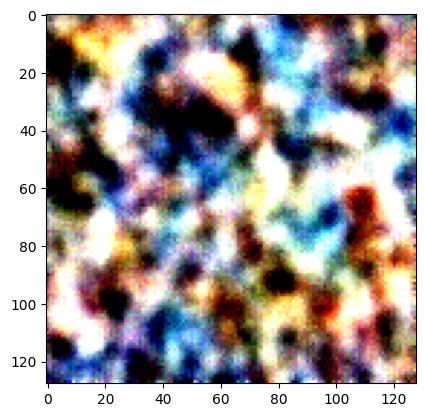

100%|██████████| 834/834 [38:06<00:00,  2.74s/it] 


Epoch: 1 | Train Loss 0.1002407


100%|██████████| 834/834 [35:40<00:00,  2.57s/it]


Epoch: 2 | Train Loss 0.0848432


100%|██████████| 834/834 [35:16<00:00,  2.54s/it]

Epoch: 3 | Train Loss 0.0809629


In [12]:
encoder=Encoder(input_channels,time_embedding,block_layers=[2,2,2,2])
decoder=Decoder(last_fmap_channels,output_channels,time_embedding,first_fmap_channels)

model=DiffusionNet(encoder,decoder).to(device)

diffusion_utils=DiffusionUtils(n_timestpes,beta_min,beta_max,device=device,scheduler=beta_scheduler)

lossfunc = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

loss=0

train_losses = []

best_loss = np.inf


for epoch in range(4):
    model.train()
    for idx,(images,lables) in enumerate(tqdm(train_loader)):
        model.zero_grad()
        images=images.to(device)
        lables=lables.to(device)

        t=diffusion_utils.sampleTimestep(size=images.shape[0])
        x_t,noise=diffusion_utils.noiseImage(images,t)
        predicted_noise=model(x_t,t)
        batch_loss=lossfunc(noise,predicted_noise)
        batch_loss.backward()
        optimizer.step()
        loss+=batch_loss.item()

    loss=loss/(idx+1)
    print(f"Epoch: {epoch} | Train Loss {loss:.7f}")

    if loss<best_loss:
        best_loss=loss
        torch.save(model.state_dict(),'../../models/best_model.pth')

    if epoch%10==0 or epoch ==(epoch-1):
        print("Generating Images")
        n=1
        x=torch.randn((n,3,128,128)).to(device)
        generated_images=diffusion_utils.sample(x,model)
        generated_images=generated_images.detach().cpu()
        generated_images=(generated_images.clamp(-1,1)+1)/2
        img=generated_images[0].permute(1,2,0).numpy()*255
        img=img.astype(np.uint8)
        plt.imshow(img)
        plt.show()



In [13]:
print("Generating Images")
n=1
x=torch.randn((n,3,128,128)).to(device)
generated_images=diffusion_utils.sample(x,model)
generated_images=generated_images.detach().cpu()
generated_images=(generated_images.clamp(-1,1)+1)/2
img=generated_images[0].permute(1,2,0).numpy()*255
img=img.astype(np.uint8)
plt.imshow(img)
plt.show()

Generating Images
